# Mapping

In response to the 2008 U.S. Farm Bill, the U.S. Department of Agriculture's [Economic Research Service](https://www.ers.usda.gov/about-ers/) compiled a [June 2009 report to Congress](https://www.ers.usda.gov/publications/pub-details/?pubid=42729):

> According to data from the latest census (2000), about 23.5 million people, or 8.4 percent of the U.S. population, live in low-income neighborhoods that are more than a mile from a supermarket. Low-income neighborhoods are areas where more than 40 percent of the population has income less than or equal to 200 percent of the Federal poverty threshold ($44,000 per year for a family of four in 2008).

In this assessment, we'll simulate their analysis by creating geospatial maps to help us understand food access in Washington. There are three geographic region types that we'll use in this assessment:

- **Census tract** is a geographic region used in the U.S. census. It is the smallest of the three region types.
- **County** is a geographic region used for administrative purposes that can include one or more census tracts.
- **State** is a geographic region such as the State of Washington. It is the largest of the three region types.

A census tract is defined as **low access** if enough people in the tract do not have nearby access to grocery stores offering affordable and nutritious food. In urban areas, "low access" is defined as 0.5 miles; in rural areas, "low access" is defined as 10 miles.

`tl_2010_53_tract00.shp` contains the 2010 US census dataset in geospatial shapefile format only for Washington state (53). The only columns you need to use are `CTIDFP00`, the census tract identifier, and `geometry`, the geometric shape of the tract.

`food_access.csv` contains the food access dataset in tabular CSV format. Each row in the dataset corresponds to a census tract for every state in the country (not just Washington). This dataset has many columns but you only need to understand the following:

- `CensusTract` is the census tract identifier.
- `State` is the state name for the census tract.
- `County` is the county name for the census tract.
- `Urban` is a flag (0 or 1) that indicates if this census tract is an urban environment.
- `Rural` is a flag that indicates if this census tract is a rural environment.
- `LATracts_half` is a flag that indicates if this census tract is "low access" in a half mile radius.
- `LATracts10` is a flag that indicates if this census tract is "low access" in a 10 mile radius.
- `LowIncomeTracts` is a flag that indicates if this census tract is "low income".
- `POP2010` is the number of people in this census tract according to the 2010 census.
- `lapophalf` is the number of people in this census tract considered having "low access" in a half mile radius.
- `lapop10` is the number of people in this census tract considered having "low access" in a 10 mile radius.
- `lalowihalf` is similar to `lapophalf` but only counts people considered low access and low income.
- `lalowi10` is similar to `lapop10` but only counts people considered low access and low income.

In [11]:
!pip install -q folium mapclassify

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Testing utilities that should not be used for implementation
from matplotlib.axes import Axes
from matplotlib.collections import PatchCollection
from folium.features import GeoJson
from folium.folium import Map
from mapping_utils import assert_patches_allclose, rural_idx, rural_la_idx, urban_ha_idx, lalowi_idx
all_counties = gpd.read_file("counties.geojson")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Outside Sources

Update the following Markdown cell to include your name and list your outside sources. Submitted work should be consistent with the curriculum and your sources.

**Name**: Asmitha Samuthrakumar
1. https://geopandas.org/en/stable/docs/user_guide/mapping.html
2. https://geopandas.org/en/latest/docs/reference/api/geopandas.GeoDataFrame.plot.html
3. https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html
4. https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html

## Task: Load in data

Write a function `load_data` that takes path for census dataset and the path for the food access dataset and returns the `GeoDataFrame` resulting from merging the two datasets on the census tract identifiers `CTIDFP00` / `CensusTract`. Assume the census tract identifier columns exist: use only these two column names. Not all census tracts have food access data, but we want to make sure to include all the census tracts data. in the resulting `GeoDataFrame`.

In [12]:
def load_data(shp_path, csv_path):
    """
    This function loads a csv file and a geopandas file, and merges the dataframes into one geodataframe based off of the Census Tract data.
    """
    sdf = gpd.read_file(shp_path)
    cdf = pd.read_csv(csv_path)
    merged_df = sdf.merge(cdf, left_on = "CTIDFP00", right_on = "CensusTract", how = "left")
    return merged_df



state_data = load_data("tl_2010_53_tract00.shp", "food_access.csv")
display(state_data)
assert type(state_data) == gpd.GeoDataFrame, "this function should return a GeoDataFrame"
assert list(state_data.columns) == [
    "STATEFP00", "COUNTYFP00", "TRACTCE00", "CTIDFP00", "NAME00", "NAMELSAD00", "MTFCC00",
    "FUNCSTAT00", "ALAND00", "AWATER00", "INTPTLAT00", "INTPTLON00", "geometry", "CensusTract",
    "State", "County", "Urban", "Rural", "LATracts_half", "LATracts10", "GroupQuartersFlag",
    "OHU2010", "NUMGQTRS", "PCTGQTRS", "LowIncomeTracts", "POP2010", "lapophalf", "lalowihalf",
    "lapop10", "lalowi10",
], "the returned data frame should include columns from both datasets"
assert state_data["CensusTract"].dtype != "object", "gpd.read_file only accepts geospatial data"
assert len(state_data) == 1318, "incorrect number of rows loaded; the two datasets are"\
                                + " not merged using the correct join type"

STATEFP00 COUNTYFP00 TRACTCE00     CTIDFP00  NAME00           NAMELSAD00  \
0           53        077    001400  53077001400      14      Census Tract 14   
1           53        077    001600  53077001600      16      Census Tract 16   
2           53        077    000700  53077000700       7       Census Tract 7   
3           53        077    002400  53077002400      24      Census Tract 24   
4           53        077    002200  53077002200      22      Census Tract 22   
...        ...        ...       ...          ...     ...                  ...   
1313        53        063    010202  53063010202  102.02  Census Tract 102.02   
1314        53        063    010301  53063010301  103.01  Census Tract 103.01   
1315        53        063    010504  53063010504  105.04  Census Tract 105.04   
1316        53        063    010303  53063010303  103.03  Census Tract 103.03   
1317        53        063    001600  53063001600      16      Census Tract 16   

     MTFCC00 FUNCSTAT00    ALAND00  AWATER00  ... GroupQuartersFlag OHU2010  \
0      G5020          S    5539748         0  ...               0.0  1203.0   
1      G5020          S   97657363   1509774  ...               NaN     NaN   
2      G5020          S    2930010         0  ...               0.0  2602.0   
3      G5020          S  232557960     69748  ...               NaN     NaN   
4      G5020          S  207645882         0  ...               0.0  2501.0   
...      ...        ...        ...       ...  ...               ...     ...   
1313   G5020          S  184070644         0  ...               0.0  2346.0   
1314   G5020          S   21667422         0  ...               0.0  1612.0   
1315   G5020          S    9371197         0  ...               0.0  1325.0   
1316   G5020          S  107033392         0  ...               0.0  1085.0   
1317   G5020          S    2104249         0  ...               0.0  1430.0   

     NUMGQTRS  PCTGQTRS LowIncomeTracts POP2010    lapophalf   lalowihalf  \
0        62.0  0.018002             1.0  3444.0  2883.838461  1594.727661   
1         NaN       NaN             NaN     NaN          NaN          NaN   
2       141.0  0.019938             1.0  7072.0  1881.362199   948.972610   
3         NaN       NaN             NaN     NaN          NaN          NaN   
4        23.0  0.002970             1.0  7745.0  6137.595205  2770.949604   
...       ...       ...             ...     ...          ...          ...   
1313      8.0  0.001146             0.0  6983.0  6842.568092   860.247108   
1314     13.0  0.003047             1.0  4266.0  3597.752448  1770.888294   
1315      0.0  0.000000             0.0  3546.0  3237.127237   517.875884   
1316     12.0  0.003971             0.0  3022.0  3022.000003   507.539103   
1317      0.0  0.000000             1.0  3738.0   145.702168    99.504575   

         lapop10   lalowi10  
0       0.000000   0.000000  
1            NaN        NaN  
2       0.000000   0.000000  
3            NaN        NaN  
4       0.000000   0.000000  
...          ...        ...  
1313  112.663119  15.763564  
1314    0.000000   0.000000  
1315    0.000000   0.000000  
1316    0.000000   0.000000  
1317    0.000000   0.000000  

[1318 rows x 30 columns]

## Task: Plot census tracts

Write a function `plot_census_map` that takes the merged data and returns the `Axes` that contains shapes of all the census tracts in Washington. Title the plot "Washington Census Tracts" and turn off axis labels.

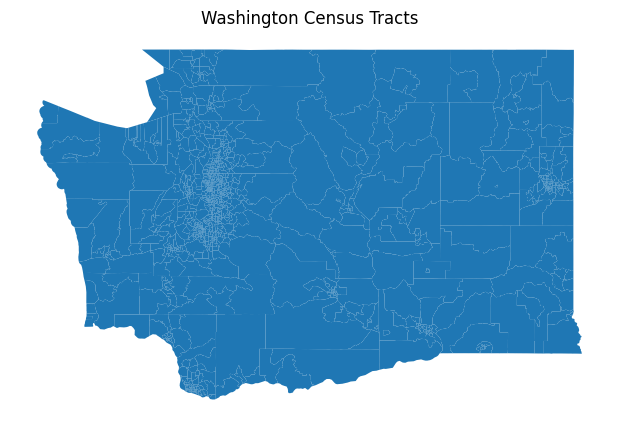

In [13]:
def plot_census_map(state_data):
    """
    This function returns a plot of all the census tracts in the given state.
    """

    fig, ax = plt.subplots(1, figsize=(10, 5))
    axes = state_data.plot(ax=ax)
    axes.set_title("Washington Census Tracts")
    axes.set_axis_off()
    return axes


ax = plot_census_map(state_data)
assert type(ax) == Axes, "this function should return an Axes object"
layers = ax.findobj(PatchCollection)
assert_patches_allclose(layers[0], geoms=state_data.geometry, num_colors=1, layer=0)
assert len(layers) == 1, f"expected to have 1 layer but got {len(layers)} layers"
assert ax.get_title() == "Washington Census Tracts", "title does not match expected"
assert not ax.axison, "borders and labels must be hidden"

## Preparing the state background

When given no arguments, the `dissolve` method considers the entire `GeoDataFrame` as a single group. This will be useful for plotting backgrounds in later tasks. We precompute this because `dissolve` is an expensive method to run (in terms of runtime).

geometry
0  POLYGON ((-122.8826 46.05175, -122.88261 46.05...

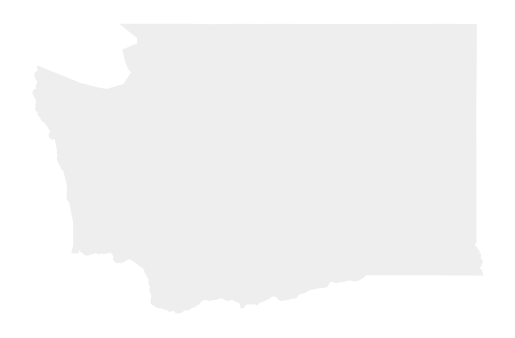

In [14]:
entire_state = state_data[["geometry"]].dissolve()
display(entire_state)
ax = entire_state.plot(color="#EEE")
ax.set_axis_off()

## Task: Plot census tract populations

Write a function `plot_census_population_map` that takes the merged data and the `entire_state` as state background and return the `Axes` that plots all the census tracts in Washington where each census tract is colored according to the `POP2010` column. There will be some missing census tracts. Underneath, plot the entire state of Washington in the background color `#EEE`. Title the plot "Washington Census Tract Populations", turn off axis labels, include a legend, and increase the figure size so that the map is the same height as the legend (hint: figure size should be roughly 2 by 1 in terms of width by height).

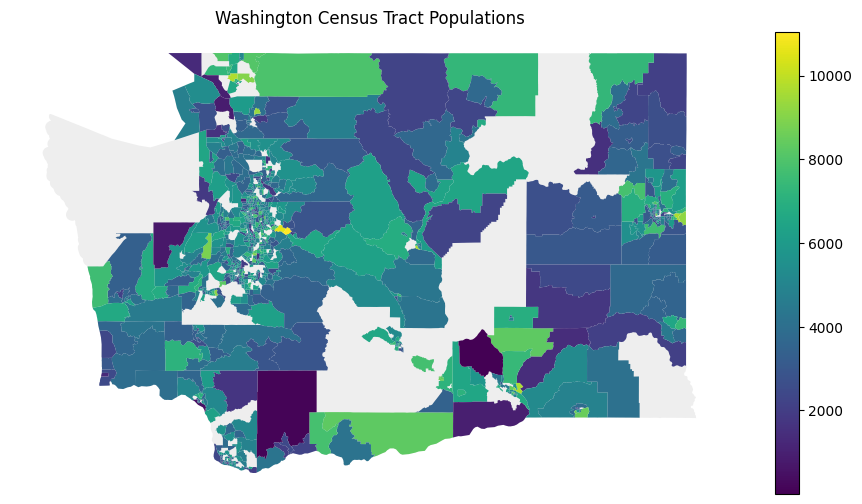

In [15]:
def plot_census_population_map(state_data, state_background):
    """
    This function creates a choropleth of the given state based off of the population for each tract. 
    """
    fig, ax = plt.subplots(1, figsize=(12, 6))
    axes = state_background.plot(ax=ax, color = "#EEE")
    axes = state_data.plot(column = "POP2010", ax = ax, legend = True)
    axes.set_title("Washington Census Tract Populations")
    axes.set_axis_off()

    return axes



ax = plot_census_population_map(state_data, entire_state)
assert type(ax) == Axes, "this function should return an Axes object"
layers = ax.findobj(PatchCollection)
assert len(layers) == 2, "expected to have 2 layers (one background and one foreground)"\
                         +f" but got {len(layers)} layer(s)"
assert_patches_allclose(layers[0], geoms=entire_state.geometry, color="#EEE", layer=0)
assert_patches_allclose(layers[1], geoms=state_data.dropna().geometry, num_colors=183, layer=1)
assert ax.get_title() == "Washington Census Tract Populations", "title does not match expected"
assert not ax.axison, "borders and labels must be hidden"
cbar = ax.get_figure().get_axes()[-1]
assert cbar.get_label() == "<colorbar>", "missing legend"
assert ax.bbox.height == cbar.bbox.height, "map can be enlarged"

## Task: Plot county populations

Write a function `plot_county_populations_map` that takes the merged data and the `entire_state` as state background and returns the `Axes` that plots all the counties in Washington where each county is colored according to the `POP2010` column. This will require combining all the census tract data and geometries for each county, though there will be missing data for some counties. Underneath, plot the entire state of Washington in the background color `#EEE`. Title the plot "Washington County Populations", turn off axis labels, include a legend, and increase the figure size so that the map is the same height as the legend (hint: figure size should be roughly 2 by 1 in terms of width by height).

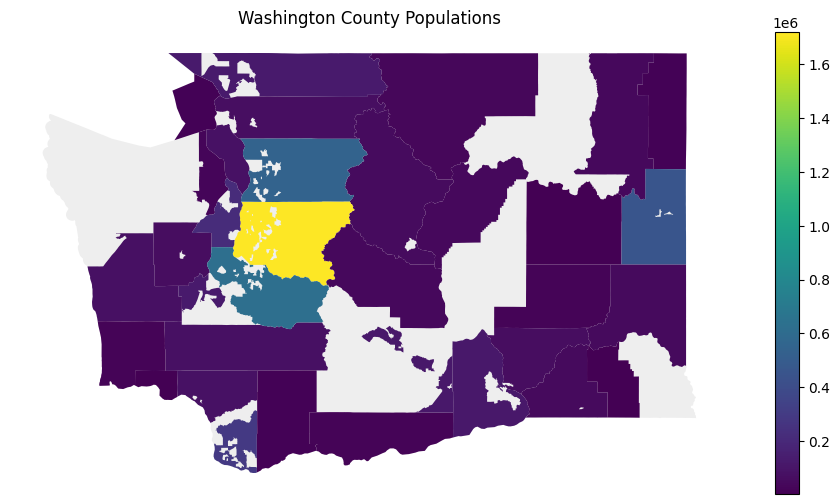

In [16]:
def plot_county_population_map(state_data, state_background):
    """
    This function plots a choropleth of the population of each county in the given state.
    """
    county_map = state_data.dissolve(by = "County", aggfunc = "sum")
    fig, ax = plt.subplots(1, figsize=(12, 6))
    axes = state_background.plot(ax=ax, color = "#EEE")
    axes = county_map.plot(ax=ax, legend = True, column = "POP2010")
    axes.set_title("Washington County Populations")
    axes.set_axis_off()
    return axes


ax = plot_county_population_map(state_data, entire_state)
assert type(ax) == Axes, "this function should return an Axes object"
layers = ax.findobj(PatchCollection)
assert len(layers) == 2, "expected to have 2 layers (one background and one foreground)"\
                         +f" but got {len(layers)} layer(s)"
assert_patches_allclose(layers[0], geoms=entire_state.geometry, color="#EEE", layer=0)
assert_patches_allclose(layers[1], geoms=all_counties.geometry, num_colors=20, layer=1)
assert ax.get_title() == "Washington County Populations", "title does not match expected"
assert not ax.axison, "borders and labels must be hidden"
cbar = ax.get_figure().get_axes()[-1]
assert cbar.get_label() == "<colorbar>", "missing legend"
assert ax.bbox.height == cbar.bbox.height, "map can be enlarged"

## Task: Plot food access by county

Write a function `plot_food_access_by_county_map` that takes the merged data and the `entire_state` as state background and returns a 4-tuple of `Axes` that represent the subplots in a 2-by-2 figure consisting of 4 choropleth maps:

- Top left plot titled "Low Access: Half Mile" showing the proportion of people per county who have low access to food within a half mile `lapophalf` out of the total population `POP2010`.
- Top right plot titled "Low Access + Low Income: Half Mile" showing the proportion of people per county considered low income who also have low access to food within a half mile `lalowihalf` out of the total population `POP2010`.
- Bottom left plot titled "Low Access: 10 Miles" showing the proportion of people per county who have low access to food within 10 miles `lapop10` out of the total population `POP2010`.
- Bottom right plot titled "Low Access + Low Income: 10 Miles" showing the proportion of people per county considered low income who also have low access to food within 10 miles `lalowi10` out of the total population `POP2010`.

When calling `plot`, specify the keyword arguments `vmin=0` and `vmax=1` so that the subplots all share the same scale. Underneath, plot the entire state of Washington in the background color `#EEE`. We recommend preparing subplots with `figsize=(15, 10)`. Turn off axis labels on each subplot.

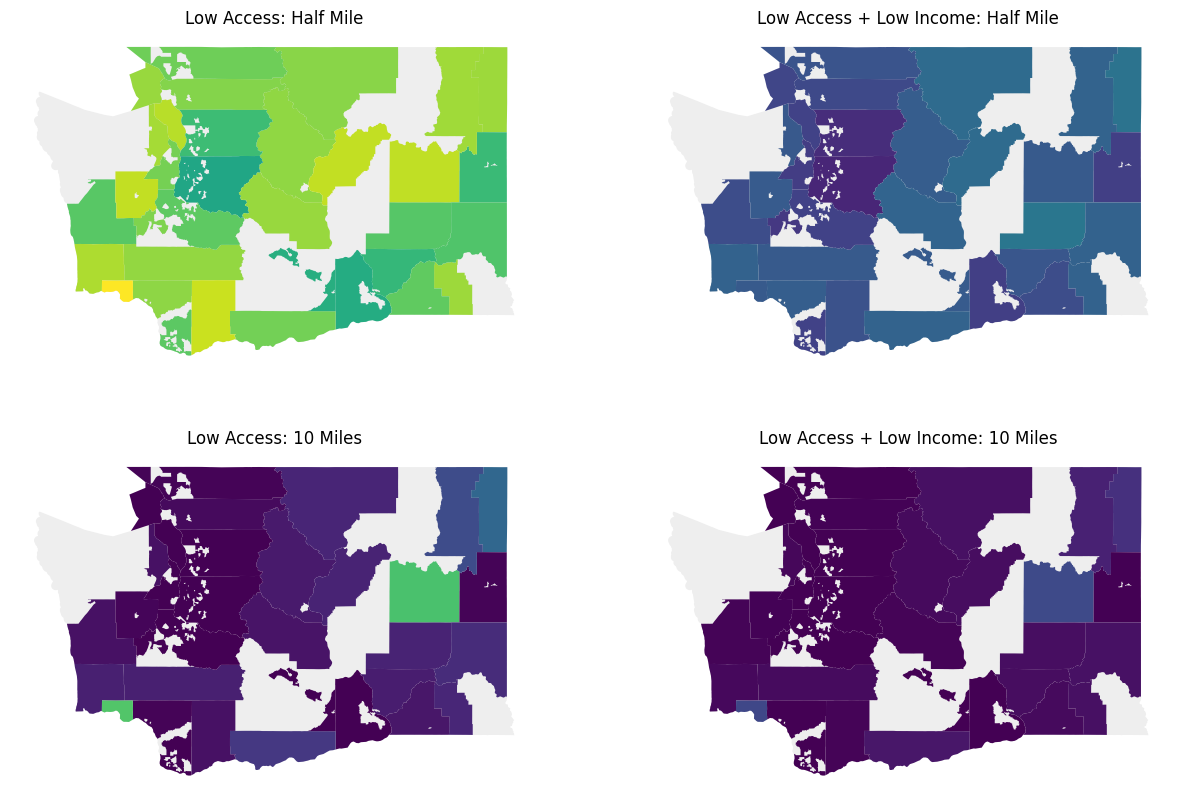

In [17]:
def plot_food_access_by_county_map(state_data, state_background):
    """
    This function returns 4 choropleth maps. The top let shows the proportion of people per county who have low access to food within a half mile out of the total population. The top right plot 
    shows the proportion of people per county considered low income who also have low access to food within a half mile out of the total population. The bottom left plot shows the proportion of
    people per county who have low access to food within 10 miles out of the total population. The bottom right plot shows the proportion of people per county considered low income who also
    have low access to food within 10 miles out of the total population.
    """
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(15, 10))
    
    for axe in [ax1, ax2, ax3, ax4]:
        axes = state_background.plot(ax=axe, color = "#EEE")
        axes.set_axis_off()
    county_map = state_data.dissolve(by = "County", aggfunc = "sum")

    county_map["lapophalf_percent"] = county_map["lapophalf"]/ county_map["POP2010"]
    axes = county_map.plot(ax=ax1, column = "lapophalf_percent", vmin = 0, vmax = 1)
    ax1.set_title("Low Access: Half Mile")
    
    county_map["lalowihalf_percent"] = county_map["lalowihalf"]/ county_map["POP2010"]
    axes = county_map.plot(ax=ax2, column = "lalowihalf_percent", vmin = 0, vmax = 1)
    ax2.set_title("Low Access + Low Income: Half Mile")
    
    county_map["lapop10_percent"] = county_map["lapop10"]/ county_map["POP2010"]
    axes = county_map.plot(ax=ax3, column = "lapop10_percent", vmin = 0, vmax = 1)
    ax3.set_title("Low Access: 10 Miles")
    
    county_map["lalowi10_percent"] = county_map["lalowi10"]/ county_map["POP2010"]
    axes = county_map.plot(ax=ax4, column = "lalowi10_percent", vmin = 0, vmax = 1)
    ax4.set_title("Low Access + Low Income: 10 Miles")
    return (ax1, ax2, ax3, ax4)


axs = plot_food_access_by_county_map(state_data, entire_state)
assert axs is not None, "this function should return a 4-tuple of Axes objects"
assert len(axs) == 4, "the returned tuple's length should be 4"
expected_titles = ["Low Access: Half Mile", "Low Access + Low Income: Half Mile",
                   "Low Access: 10 Miles", "Low Access + Low Income: 10 Miles"]
for ax, expected_num_colors, expected_title in zip(axs, [31, 23, 19, 16], expected_titles):
    assert type(ax) == Axes, "each value in the returned tuple should be an Axes object"
    layers = ax.findobj(PatchCollection)
    assert len(layers) == 2, "expected to have 2 layers (one background and one foreground)"\
                             +f" but got {len(layers)} layer(s)"
    assert_patches_allclose(layers[0], geoms=entire_state.geometry, color="#EEE", layer=0)
    assert_patches_allclose(layers[1], geoms=all_counties.geometry, num_colors=expected_num_colors, layer=1)
    assert ax.get_title() == expected_title, f"title {ax.get_title()} does not match expected"
    assert ax.get_legend() is None, "plot should not have a legend"
    assert not ax.axison, "borders and labels must be hidden"

## Writeup: Food access by county

Setting aside the lack of a legend in `plot_food_access_by_county_map`, is it an effective visualization? Using the data visualization principles we learned in class, explain why or why not.

**Answer**: Yes, it is an effective visualizing (disregarging the lack of a legend)! It effectively compares each county by color for each of the listed conditions. Each plot is clearly labeled, which avoids misconceptions and misleading data. It is also not playful, and captures the seriousness of the topic it covers.

## Task: Plot low access census tracts

Write a function `plot_census_low_access_map` that takes the merged data and the `entire_state` as state background and returns the `Axes` that plots all census tracts (not counties) considered low access using 5 `plot` layers for the following definitions for "low access" in urban and rural tracts. For this task, do not use the `LATracts_half` or `LATracts10` columns in the merged data; the procedure described below intentionally results in different values. Your 5 plot layers should be in the following order:

1. Plot the map of Washington in the background with color `#EEE`.

1. Plot all the `Urban` census tracts for which we have food access data in the color `#AAA`.

1. Plot all the `Rural` census tracts for which we have food access data in the color `#AAA`.

1. Plot all the `Urban` census tracts considered low access in the default (blue) color.

    **Low access in an urban census tract** is defined by a `lapophalf` value that is at least 500 people or at least 33% of the census tract population.

1. Plot all the `Rural` census tracts considered low access in the default (blue) color.

    **Low access in a rural census tract** is defined by a `lapop10` value that is at least 500 people or at least 33% of the census tract population.

Finally, title the plot "Low Access Census Tracts" and turn off axis labels.

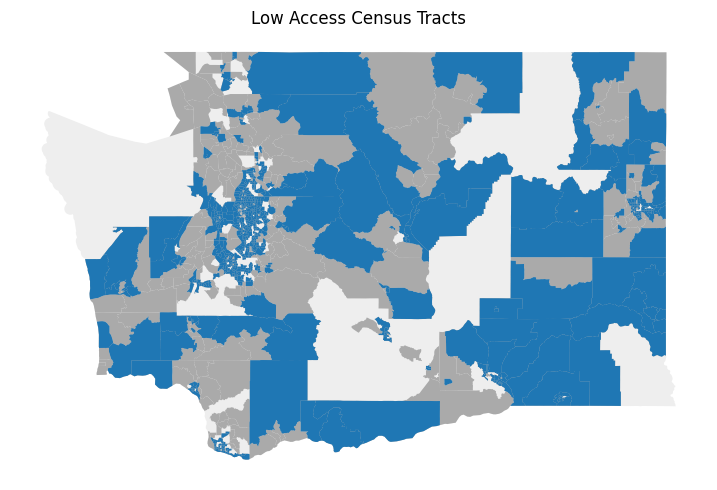

In [18]:
def plot_census_low_access_map(state_data, state_background):
    """
    This function returns a plot of the tracts that low access in an urban census tract or in a rural census tract.
    """
    
    fig, ax = plt.subplots(1, figsize=(9, 6))
    ax = state_background.plot(ax = ax, color = "#EEE")
    #tract_map = state_data.dissolve(by = "CensusTract", aggfunc = "sum")
    
    urban_tracts = state_data[(state_data["Urban"] == 1)]
    ax = urban_tracts.plot(color = "#AAA", ax=ax)

    rural_tracts = state_data[(state_data["Rural"] == 1)]
    ax = rural_tracts.plot(color = "#AAA", ax=ax)

    low_urban_tract = state_data[(state_data["Urban"] == 1) & ((state_data["lapophalf"] >= 500)|(state_data["lapophalf"]/state_data["POP2010"]>= 0.33))]
    ax = low_urban_tract.plot(ax=ax)

    low_rural_tract = state_data[(state_data["Rural"] == 1) & ((state_data["lapop10"] >= 500) | (state_data["lapop10"]/state_data["POP2010"] >= 0.33))]
    ax = low_rural_tract.plot(ax=ax)

    ax.set_title("Low Access Census Tracts")
    ax.set_axis_off()

    return ax


ax = plot_census_low_access_map(state_data, entire_state)
assert type(ax) == Axes, "this function should return an Axes object"
layers = ax.findobj(PatchCollection)
assert len(layers) == 5, "expected to have 5 layers (one background and 4 foregrounds)"\
                         +f" but got {len(layers)} layer(s)"
assert_patches_allclose(layers[0], geoms=entire_state.geometry, color="#EEE", layer=0)
urban_idx = state_data["Urban"].notna() & ~state_data.index.isin(rural_idx)
urban_la_idx = urban_idx & ~state_data.index.isin(urban_ha_idx)
try:
    assert_patches_allclose(layers[1], geoms=state_data.loc[urban_idx, "geometry"], color="#AAA", layer=1)
    assert_patches_allclose(layers[2], geoms=state_data.loc[rural_idx, "geometry"], color="#AAA", layer=2)
    assert_patches_allclose(layers[3], geoms=state_data.loc[urban_la_idx, "geometry"], layer=3)
    assert_patches_allclose(layers[4], geoms=state_data.loc[rural_la_idx, "geometry"], layer=4)
    ## Debugging tip: if you want to check one layer, comment out the four lines above
    ## and use each of the following lines ONE AT A TIME
    #assert_patches_allclose(layers[1], geoms=state_data.loc[urban_idx, "geometry"], color="#AAA", layer=1)
    # assert_patches_allclose(layers[1], geoms=state_data.loc[rural_idx, "geometry"], color="#AAA", layer=1)
    # assert_patches_allclose(layers[1], geoms=state_data.loc[urban_la_idx, "geometry"], layer=1)
    # assert_patches_allclose(layers[1], geoms=state_data.loc[rural_la_idx, "geometry"], layer=1)
except AssertionError as e:
    # this message was to remind you to plot in the correct order; you can ignore if you just kept one layer
    print("Please make sure the order of your plot is correct, and also check any other errors below.")
    raise e
assert ax.get_title() == "Low Access Census Tracts", "title does not match expected"
assert not ax.axison, "borders and labels must be hidden"

## Writeup: Data-driven decision-making

What is one way that government or food access organizations could use `plot_food_access_by_county_map` or `plot_census_low_access_map` to shape their decisions or policies? Then, explain one limitation or concern with using the plots in the way you suggested.

**Answer**: A food access organization could use the plot census low access map to determine where they should be allocating more resources. However, this plot in particular does not show the varying degree of severity, which may result in certain tracts being overlooked as it may be more expensive to reach them.

## Task: Interactive map

Although the initial report to Congress was completed in June 2009, the Economic Research Service has since then maintained an interactive map for their [**Food Access Research Atlas**](https://gisportal.ers.usda.gov/ers/GIS_FARA/lowincome_lowaccess.html). Open this interactive map, turn off the default layer "LI and LA and 1 and 10 miles", and turn on the layer "LI and LA at 1/2 and 10 miles". This layer displays:

> Low-income census tracts where a significant number or share of residents is more than 1/2 mile (urban) or 10 miles (rural) from the nearest supermarket.

Write a function `interactive_map` that returns a interactive `Map` of low income and low access census tracts in Washington. Include only `LowIncomeTracts` that are either low access at half a mile `LATracts_half` for `Urban` census tracts or low access at 10 miles `LATracts10` for `Rural` census tracts. This dataset does not match the Food Access Research Atlas, so some differences are to be expected. Your interactive map won't appear in the PDF printout as PDF files cannot embed interactive maps so don't worry about it not showing up in your PDF export.

In [19]:
def interactive_map(state_data):
    """
    Returns an interactive map that indicates the tracts classified as Low Income, and if urban are low access at half a mile, but if rural are low access at 10 miles.
    """
    low_income_tracts = state_data[(state_data["LowIncomeTracts"] == 1) & (((state_data["Urban"] == 1) & (state_data["LATracts_half"] == 1)) | ((state_data["Rural"] == 1) & (state_data["LATracts10"] == 1)))]
    return low_income_tracts.explore()

map = interactive_map(state_data)
assert type(map) == Map, "this function should return an interactive Map object"
display(map)
last_child = next(reversed(map._children.values()))
assert type(last_child) == GeoJson, "last child should be GeoJson; do not specify column"
geojson = last_child.data
assert set(int(d["id"]) for d in geojson["features"]) == set(lalowi_idx), "wrong selection"

The following cell plots a preview of your interactive map for the PDF printout.

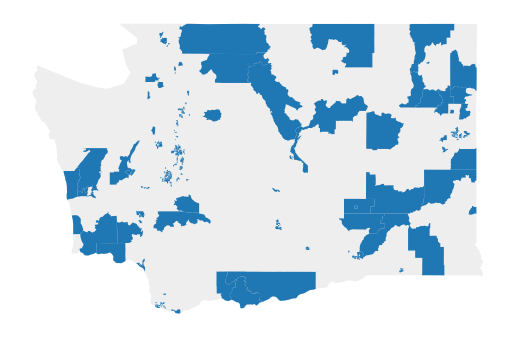

In [20]:
gpd.GeoDataFrame.from_features(geojson, crs="EPSG:4326").plot(ax=entire_state.plot(color="#EEE")).set_axis_off()

## Writeup: Build a new supermarket

Using the interactive map above, locate the low-income low-access census tract closest to your favorite place in Washington. Then, identify a location (a specific street intersection, such as "University Way NE & NE 45th St") to add a new supermarket that would serve the people living in that census tract. Finally, explain the considerations that factored into your choice of location.

This dataset is outdated, so assume there are no supermarkets in any low-income low-access census tract even if supermarkets are present today. An effective writeup will demonstrate expertise with the data setting.

**Answer**: I would add a new supermarket at East Stevens Way Northeast because it lies within the low-income low access census tract identified on the interactive map. This street is located on the University of Washington campus. More than half of the people in this area are considered having "low access" in a half mile radius, which affects nearly 3000 people. A supermarket in this location would provide convenient access to the residents who are facing barriers in finding food, and can help foster a future generation of well-fed individuals.